In [26]:
# importing the packages
using POMDPs
using POMDPTools # Tools to define MDP, e.g., SparseCat, stepthrough
using POMDPModelTools 
using Plots; default(fontfamily="Computer Modern", framestyle=:box)
using Plots.PlotMeasures
using DiscreteValueIteration 
using CSV, DataFrames 
using ArgParse
using POMCPOW
using BasicPOMCP
using POMDPPolicies
using SARSOP
using QMDP


# define the arguments
function parse_commandline()
    arg = ArgParseSettings()

    @add_arg_table arg begin
        "--name" 
            help="output file name's id" 
            arg_type=String
            default="1"
        "--discount_factor" 
            help="discount factor" 
            arg_type=Float64
            default=0.95
        "--max_steps" 
            help="max steps" 
            arg_type=Int
            default=32
    end
    return parse_args(arg)
end

# parse the arguments
parsed_args = parse_commandline()


# human and robot are at an intersection (stop signs)
# they both start stopped (i.e., at position = 0)
# the game resets after one agent goes (i.e., at position = 1)

# this the global variable for eveything
# stores the most recent human action
human_action = nothing # noting is like None in Python


In [27]:
# define the state type
mutable struct pomdpState
    hums::Int # human position
    robs::Int # robot position
    z::Int
    phi::Int
end

# define the observation type
struct pomdpObservation
    hums::Int # human position
    robs::Int # robot position
    human_action::Int # human action
end

#return probability of action = "stop"
function human_policy(hums, robs,  z)
    # # workaround for the case where s = (0, 0)
    # Do we need this workaround?
    if hums != 0 || robs !=0 
        return 0.5
    end
    # z = 0 is a defensive human
    if z == 0
        return 0.9
    else
    # z = 1 is an aggressive human        
        return 0.1
    end
end

# return updated z
function human_dynamics(hums, robs, z, phi)
    # phi = 0 is a human who never changes z
    if phi == 0
        return z
    # phi = 1 is a human who changes
    else
        # if a collision occurs
        if hums == 1 && robs == 1
            return 0
        else
            return z
        end
    end
end

# defining the pomdp model type
struct pomdpWorld <: POMDP{pomdpState, Int, pomdpObservation}
    discount_factor::Float64 # discount 
end

# constructor for convenience
function pomdpWorld(;discount_factor::Float64=0.95)
    return pomdpWorld(discount_factor)
end

# define the state space
function POMDPs.states(pomdp::pomdpWorld)
    s = State[] # empty array of states
    # loop over all possible states
    for hums = 0:1, robs = 0:1, z = 0:1, phi = 0:1
        push!(s, State(hums, robs, z, phi))
    end
    return s
end

# define the action space
# action are 0 (stop) and 1 (go) as ints
POMDPs.actions(pomdp::pomdpWorld) = [0, 1]

# define the transition function
function POMDPs.transition(pomdp::pomdpWorld, state::pomdpState, action::Int64)
    hums, robs, z, phi = state.hums, state.robs, state.z, state.phi
    a = action
    p_stop = human_policy(hums, robs, z)
    z1 = human_dynamics(hums, robs, z, phi)

    # reset
    if hums > 0 || robs > 0
        return Deterministic(pomdpState(0,0,z1,phi))
    end

    # move robot car
    # becaue of s1 we need a mutable struct for state
    s1 = pomdpState(hums, robs, z1, phi)
    if a == 1
        s1.robs += 1
    end

    # move human car
    global human_action
    if rand() < p_stop
        human_action = 0
        return Deterministic(s1)
    else
        s1.hums += 1
        human_action = 1
        return Deterministic(s1)
    end
end

In [28]:
# define the observation space
function POMDPs.observations(pomdp::pomdpWorld)
    o = pomdpObservation[] # empty array of observations
    # loop over all possible observations
    for hums = 0:1, robs = 0:1, human_action = 0:1
        push!(o, pomdpObservation(hums, robs, human_action))
    end
    return o
end


# observation index
function POMDPs.obsindex(pomdp::pomdpWorld, o::pomdpObservation)
    hums = o.hums
    robs = o.robs
    human_action = o.human_action
    # observation is a number between 1 and 8
    return hums + 2*robs + 4*human_action + 1 
end

# observation function
# this funciton needs to be sampling based (probabilistic)
function POMDPs.observation(pomdp::pomdpWorld, state::pomdpState, action::Int64, statep::pomdpState)
    hums = statep.hums
    robs = statep.robs
    action = human_action
    return Deterministic(pomdpObservation(hums, robs, action))

end

# define the reward function
function POMDPs.reward(pomdp::pomdpWorld, state::pomdpState, action::Int)
    hums = state.hums
    robs = state.robs
    # no one goes
    if hums == 0 && robs == 0
        return 0
    end
    # human goes through first
    if hums == 1 && robs == 0
        return -3
    end
    # both go and we crash
    if hums == 1 && robs == 1
        return -10
    end
    # robot goes through first
    if hums == 0 && robs == 1
        return +5
    end
end


# MISC functions
POMDPs.discount(pomdp::pomdpWorld) = pomdp.discount_factor
# Indexing functions
function POMDPs.stateindex(pomdp::pomdpWorld, s::pomdpState)
    hums = s.hums
    robs = s.robs
    z = s.z
    phi = s.phi
    # state is a number between 1 and 16
    return hums + 2*robs + 4*z + 8*phi + 1 
end

# action index
function POMDPs.actionindex(pomdp::pomdpWorld, a::Int)
    return a + 1
end

# human is initially aggressive, not sure if phi = 0 or 1
# if phi = 0 then we cannot change z
# if phi = 1 then we can make human defensive by crashing

# function POMDPs.initialstate(pomdp::pomdpWorld)
#     if rand() < 0.5
#         return Deterministic(pomdpState(0, 0, 1, 1))
#     else
#         return Deterministic(pomdpState(0, 0, 1, 0))
#     end
# end

In [29]:
# Initialize an array to store the cumulative rewards for each run
cum_rwd_runs = Array{Array{Int,1},1}()
crossings_first_50 = 0
crossings_last_50 = 0
rest_first_50 = 0
rest_last_50 = 0
collisions_first_50 = 0
collisions_last_50 = 0
yieldings_first_50 = 0
yieldings_last_50 = 0


for iteration in 1:100
    POMDPs.initialstate(pomdp::pomdpWorld) = rand([Deterministic(pomdpState(0, 0, 1, 0)),Deterministic(pomdpState(0, 0, 1, 1))])
    if iteration <= 50
        init_belief = SparseCat([(pomdpState(0, 0, 1, 1)), pomdpState(0,0,1,0)], [1.0, 0.0])
    else
        init_belief = SparseCat([(pomdpState(0, 0, 1, 1)), pomdpState(0,0,1,0)], [0.0, 1.0])
    end
        # definition is done, lets solve it
    pomdp = pomdpWorld()
    # println("Initial state: ", initialstate(pomdp))
    # solver = SARSOPSolver()
    solver = POMCPSolver()
    planner = solve(solver, pomdp)
    belief_updater = updater(planner)

    human_pos = []
    robot_pos = []
    human_z = []
    human_phi = []
    reward = []


    # run the simulation
    for (s, a, o, r) in stepthrough(pomdp, planner, belief_updater, init_belief, "s,a,o,r", max_steps=parsed_args["max_steps"])
        push!(human_pos, s.hums)
        push!(robot_pos, s.robs)
        push!(reward, r)
        push!(human_z, s.z)
        push!(human_phi, s.phi)
        # push!(reward, POMDPs.reward(pomdp, s, a))
        if s.hums > s.robs
            if iteration <= 50
                crossings_first_50 += 1
            else
                crossings_last_50 += 1
            end
        elseif s.hums == s.robs && s.robs == 1
            if iteration <= 50
                collisions_first_50 += 1
            else
                collisions_last_50 += 1
            end
        elseif s.hums == s.robs && s.robs == 0
            if iteration <= 50
                rest_first_50 += 1
            else
                rest_last_50 += 1
            end
        else
            if iteration <= 50
                yieldings_first_50 += 1
            else
                yieldings_last_50 += 1
            end
        end
    end
    ## Append cum_rwd to the runs array
    cum_rwd =cumsum(reward)
    push!(cum_rwd_runs, cum_rwd)
end

    

In [30]:
max_length = maximum(length.(cum_rwd_runs))
averages = zeros(max_length)
counts = zeros(Int, max_length)
sum_of_squares = zeros(max_length) # To store the sum of squared differences

# Define the title as a string
plot_title = "Cummulative Reward Distribution for MDP"

for run in cum_rwd_runs
    for (index, value) in enumerate(run)
        averages[index] += value
        counts[index] += 1
    end
end

averages ./= counts

# Calculate sum of squared differences
for run in cum_rwd_runs
    for (index, value) in enumerate(run)
        sum_of_squares[index] += (value - averages[index])^2
    end
end

# Calculate standard deviation
std_devs = sqrt.(sum_of_squares ./ counts)

y1 = averages + std_devs
y2 = averages - std_devs


p = plot(averages, ribbon = std_devs , fillalpha = 0.35, c = 1, lw = 2, title="Cummulative Reward Distribution for MDP", xlabel="Step", ylabel="Cummulative Reward", legend = :topleft, label = "Mean")
plot!(p, y1, line = :scatter, msw = 0, ms = 2.5, label = "Upper bound")
plot!(p, y2, line = :scatter, msw = 0, ms = 2.5, label = "Lower bound")

# Replace spaces with underscores in the title for the file name
file_name = replace(plot_title, " " => "_")

# Save the plot in SVG format with the title as the file name
savefig(p, "$(file_name).svg")

"/home/bala/Fall23/aizen/pomdp_test/Cummulative_Reward_Distribution_for_MDP.svg"

In [31]:
averages

32-element Vector{Float64}:
   0.0
  -5.16
  -5.29
  -8.17
  -8.39
 -11.61
 -11.89
 -14.81
 -15.02
 -17.44
   ⋮
 -35.87
 -35.94
 -37.87
 -37.61
 -39.8
 -39.87
 -41.62
 -41.82
 -44.14

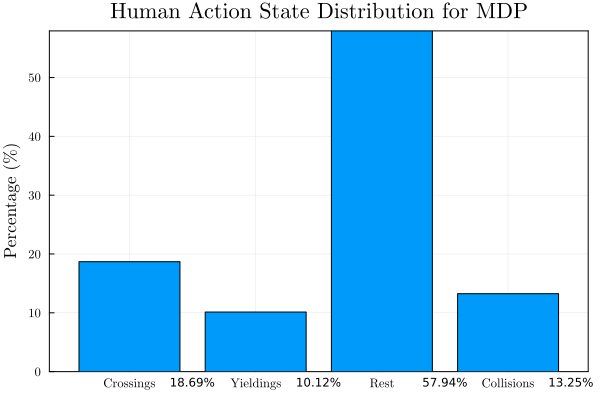

"/home/bala/Fall23/aizen/pomdp_test/Human_Action_State_Distribution_for_MDP.svg"

In [32]:
# Calculate totals for first 50 and last 50 iterations
total_crossings = crossings_first_50 + crossings_last_50
total_yieldings = yieldings_first_50 + yieldings_last_50
total_rest = rest_first_50 + rest_last_50
total_collisions = collisions_first_50 + collisions_last_50

# Calculate total events
total_events = total_crossings + total_yieldings + total_rest + total_collisions

# Calculate percentages
percent_crossings = (total_crossings / total_events) * 100
percent_yieldings = (total_yieldings / total_events) * 100
percent_rest = (total_rest / total_events) * 100
percent_collisions = (total_collisions / total_events) * 100

# Data for bar chart
categories = ["Crossings", "Yieldings", "Rest", "Collisions"]
percentages = [percent_crossings, percent_yieldings, percent_rest, percent_collisions]

# Plot
p = bar(categories, percentages, title="Human Action State Distribution for MDP", ylabel="Percentage (%)", legend=false)

y_offset = -1.8  # Adjust this offset if needed
for (i, pct) in enumerate(percentages)
    annotate!(p, [i], [y_offset], text(string(round(pct, digits=2)) * "%", :center, 8))  # Adjusting text position and size
end

# Display the plot
display(p)

# Define the title as a string
plot_title = "Human Action State Distribution for MDP"

# Replace spaces with underscores in the title for the file name
file_name = replace(plot_title, " " => "_")

# Save the plot in SVG format with the title as the file name
savefig(p, "$(file_name).svg")

In [20]:
# # ########### Plotting ############
# # nice function!
# cum_reward = cumsum(reward)
# print("Reward: ", reward)
# println("")
# print("Cum Reward: ", cum_reward)

# function plot_results(human_pos, robot_pos, cum_reward, human_z, human_phi)
#     p1 = plot(human_pos, color=:green, legend = false,
#         xlabel="time step", ylabel="position", 
#         title="Human", 
#         marker=:circle, linestyle=:solid)
#     p2 = plot(robot_pos, color=:darkkhaki, legend = false,
#         xlabel="time step", ylabel="position", 
#         title="Robot", 
#         marker=:circle, linestyle=:solid)
#     p3 = plot(cum_reward, color=:blue, legend = false,
#         xlabel="time step", ylabel="reward", 
#         title="Cumulative Reward", 
#         marker=:circle, linestyle=:solid)
#     p4 = plot(human_z, color=:red, legend = false,
#         xlabel="time step", ylabel="z",
#         title="z" , ylims=(-0.2,1.2),
#         marker=:circle, linestyle=:solid)
#     # add human_phi
#     annotate!(p4, [(1, -0.6, "phi = " * string(human_phi[1]))])
#     plot(p1, p2, p3, p4, layout=(4,1), size=(600,800))
#     display(plot(p1, p2, p3, p4, layout=(4,1), size=(600,800), show = true))
#     # gui()
# end;

# plot_results(human_pos, robot_pos, cum_reward, human_z, human_phi)

# ########### Save the data ############
# # # Create a DataFrame 
# df = DataFrame(human_pos = human_pos, robot_pos = robot_pos, cum_reward = cum_reward, human_phi = human_phi)
# directoryPath = dirname(@__FILE__)
# mkpath(directoryPath * "/data")
# CSV.write(directoryPath * "/data/pomdp_" * parsed_args["name"] * ".csv", df, writeheader=false)